In [1]:
from math import cos, sin, sqrt
from numpy import pi
from PIL import Image
from IPython.display import display, clear_output
import numpy as np
from numba import njit,prange

In [2]:
R = 10.0
n = 1.5 #number of twists
width = 1 #on each side

#for n = 3/2
critical_points = np.round(np.array([0.0, pi/3, pi/2, 2/3 * pi, pi, 4/3 * pi, 1.5*pi, 5/3*pi]), decimals=13)

In [3]:
def mob_point(tm,w):
    x = w
    y = tm
    xcy2 = x*cos(n*y)
    return (((R + xcy2)*cos(y)), ((R + xcy2)*sin(y)), x*sin(n*y))

In [4]:
@njit
def tl1(tm, x0, y0, z0, vx, vy, vz): #vx, vy
    stm = sin(tm)
    ctm = cos(tm)
    return (x0*stm - y0*ctm)/(vy*ctm - vx*stm)

@njit
def tl2(tm, x0, y0, z0, vx, vy, vz):#vy, vz
    ntm = n*tm
    sntm = sin(ntm)
    stm = sin(tm)
    cntm = cos(ntm)
    return ((y0 - R*stm)*sntm - z0*stm*cntm)/(vz*stm*cntm - vy*sntm)

@njit
def tl3(tm, x0, y0, z0, vx, vy, vz):#vx, vz
    ntm = n*tm
    sntm = sin(ntm)
    cntm = cos(ntm)
    ctm = cos(tm)
    return ((x0 - R*ctm)*sntm - z0*ctm*cntm)/(vz*ctm*cntm - vx*sntm)

In [5]:
@njit
def w1(tl, tm, x0, y0, z0, vx, vy, vz):
    return (x0 + vx*tl - R*cos(tm))/(cos(tm)*cos(n*tm))

@njit
def w2(tl, tm, x0, y0, z0, vx, vy, vz):
    return (y0 + vy*tl - R*sin(tm))/(sin(tm)*cos(n*tm))

@njit
def w3(tl, tm, x0, y0, z0, vx, vy, vz):
    return (z0 + vz*tl)/sin(n*tm)

In [6]:
@njit
def findw(tl, tm, x0, y0, z0, vx, vy, vz):
    try:
        return w1(tl, tm, x0, y0, z0, vx, vy, vz)
    except:
        pass
    
    try:
        return w2(tl, tm, x0, y0, z0, vx, vy, vz)
    except:
        pass
    
    try:
        return w3(tl, tm, x0, y0, z0, vx, vy, vz)
    except:
        pass
    
    return 2*width

In [7]:
@njit
def newton(guess, r0, v, verbose=False):
    tol = 1e-6
    
    x0,y0,z0 = r0[0], r0[1], r0[2]
    vx,vy,vz = v[0], v[1], v[2]
    
    if vx != 0:
#         e1 = tl1
#         e2 = tl3
        for i in range(50): 
            sx = tl1(guess, x0, y0, z0, vx, vy, vz) - tl3(guess, x0, y0, z0, vx, vy, vz)
            ds = (tl1(guess+tol, x0, y0, z0, vx, vy, vz) - tl1(guess-tol, x0, y0, z0, vx, vy, vz) - tl3(guess+tol, x0, y0, z0, vx, vy, vz) + tl3(guess-tol, x0, y0, z0, vx, vy, vz))/(2*tol)
            if ds != 0:
                guess -= sx/ds
        guess %= (2*pi)
        return guess
    elif vy != 0:
#         e1 = tl1
#         e2 = tl2
        for i in range(50): 
            sx = tl1(guess, x0, y0, z0, vx, vy, vz) - tl2(guess, x0, y0, z0, vx, vy, vz)
            ds = (tl1(guess+tol, x0, y0, z0, vx, vy, vz) - tl1(guess-tol, x0, y0, z0, vx, vy, vz) - tl2(guess+tol, x0, y0, z0, vx, vy, vz) + tl2(guess-tol, x0, y0, z0, vx, vy, vz))/(2*tol)
#             if verbose:
#                 print("x = " + str(guess))
#                 print("sx = " + str(sx))
#                 print("ds(x) = " + str(ds))
            if ds != 0:
                guess -= sx/ds
        guess %= (2*pi)
        return guess
    elif vz != 0:
#         e1 = tl2
#         e2 = tl3
        for i in range(50): 
            sx = tl2(guess, x0, y0, z0, vx, vy, vz) - tl3(guess, x0, y0, z0, vx, vy, vz)
            ds = (tl2(guess+tol, x0, y0, z0, vx, vy, vz) - tl2(guess-tol, x0, y0, z0, vx, vy, vz) - tl3(guess+tol, x0, y0, z0, vx, vy, vz) + tl3(guess-tol, x0, y0, z0, vx, vy, vz))/(2*tol)
#             if verbose:
#                 print("x = " + str(guess))
#                 print("sx = " + str(sx))
#                 print("ds(x) = " + str(ds))
            if ds != 0:
                guess -= sx/ds
        guess %= (2*pi)
        return guess
    else:
        return None
    
#     for i in range(40): 
#         sx = e1(guess, *r0, *v) - e2(guess, *r0, *v)
#         ds = (e1(guess+tol, *r0, *v) - e1(guess-tol, *r0, *v) - e2(guess+tol, *r0, *v) + e2(guess-tol, *r0, *v))/(2*tol)
#         if verbose:
#             print("x = " + str(guess))
#             print("sx = " + str(sx))
#             print("ds(x) = " + str(ds))
#         guess -= sx/ds
#     guess %= (2*pi)
# #     print(x)
#     return guess

In [8]:
@njit
def int2(r0, v):
    
    splits = 67
    angles = set()
    round_deci = 14
    
    for i in range(splits):
        angle = ((i+0.5)/splits) * 2 * pi
        newt = newton(angle, r0, v)
        a = round(newt, round_deci) % round(2*pi, round_deci)
        angles.add(a)
        
    return angles

In [9]:
r0 = np.array([10,0,1], dtype=np.float64)
v = np.array([0,0,-1], dtype=np.float64)
int2(r0,v)

{0.0, 4.8e-13, 2.0943951023932, 4.18879020478639}

In [10]:
@njit
def line_int(r0, v0, r1, v1):
    tol = 1e-7
    
    a = r0[0] - r1[0]
    b = r0[1] - r1[1]
    c = r0[2] - r1[2]
    d = v0[0]
    e = v0[1]
    f = v0[2]
    g = v1[0]
    h = v1[1]
    j = v1[2]
    
    #https://www.wolframalpha.com/input/?i=grad+sqrt%28%28a+%2B+d+x+-+g+y%29%5E2+%2B+%28b+%2B+e+x+-+h+y%29%5E2+%2B+%28c+%2B+f+x+-+j+y%29%5E2%29
    # matrix is [[q,r],[s,t]] 
    # let * represent dot product
    # matrix is [[v0*v0, -v0*v1],[-v1*v0, v1*v1]]
    q = d*d + e*e + f*f
    r = -1*(d*g + e*h + f*j)
    s = r
    t = g*g + h*h + j*j
    
    u = -1*(a*d + b*e + c*f)
    v = (a*g + b*h + c*j)
    
    #do matrix inverse solve
    if(q*t - r*s) > 0:
        p = 1/(q*t - r*s)
        x = p*(t*u - s*v)
        y = p*(q*v - r*u)
        dist = sqrt((a + d*x - g*y)**2 + (b + e*x - h*y)**2 + (c + f*x - j*y)**2)
#         print(x, y, dist)
        if (dist <= tol and y <= width and y >= -width):
            return True
    
    return False

In [11]:
r0 = np.array([1,0,0], dtype=np.float64)
v0 = np.array([0,1,1], dtype=np.float64)
r1 = np.array([0,1,0], dtype=np.float64)
v1 = np.array([0,-1,1], dtype=np.float64)
line_int(r0,v0,r1,v1)

False

In [12]:
@njit
def intersect(r0, v):
    angles = int2(r0,v)
    for a in angles:
        r1 = np.array([R*cos(a), R*sin(a), 0.0], dtype=np.float64)
        v1 = np.array([cos(a)*cos(a*n), sin(a)*cos(a*n), sin(a*n)], dtype=np.float64)
#         print(a, r1, v1)
        if line_int(r0, v, r1, v1):
            return True
    return False
    
#     for tm in angles:
#         ntm = n*tm
#         ctm = cos(tm)
#         stm = sin(tm)
#         cntm = cos(ntm)
#         sntm = sin(ntm)
#         r1 = [cntm*ctm, -vx]
#         r2 = [cntm*stm, -vy]
#         r3 = [sntm, -vz]
#         s1 = x0 - R*ctm
#         s2 = y0 - R*stm
#         s3 = z0

#         sols = []
#         try:
#             sol = np.linalg.solve(np.array([r1,r2]), np.array([s1,s2]))
#             sols.append(sol)
#         except:
#             pass
#         try:
#             sol = np.linalg.solve(np.array([r2,r3]), np.array([s2,s3]))
#             sols.append(sol)
#         except:
#             pass
#         try:
#             sol = np.linalg.solve(np.array([r3,r1]), np.array([s3,s1]))
#             sols.append(sol)
#         except:
#             pass
        
#         found = False
# #         print(tm)
        
#         if len(sols) == 1:
# #             print(sols[0])
#             found = True
#         if len(sols) == 2:
#             if np.all(sols[0] == sols[1]):
# #                 print(sols[0])
#                 found = True

#         if len(sols) == 3:
#             if np.all(sols[0] == sols[1]) and np.all(sols[1] == sols[2]) :
# #                 print(sols[0])
#                 found = True
#         if found:
#             angles.add(round(tm, 13))

        
#     for i in range(1,64):
#         try: 
#             newt = newton(i*0.1, r0, v)
#             nn = round(newt, 13)
#             if nn <= 6.28318530718:
#     #             print(nn)
#                 angles.add(nn)
#         except:
# #             print(i*0.1)
#             pass
#     hit = False;
# #     print(angles)
    
#     for a in angles:
# #         print("\n" + str(a) + ":")
#         try:
#             tl = tl1(a, *r0, *v)
#             xyz = (r0[0] + tl*v[0], r0[1] + tl*v[1], r0[2] + tl*v[2])
#             w = findw(tl,a, *r0, *v)
# #             print(str(tl) + ": " + str(xyz) + ", " + str(w))
#             if(w >= -width and w <= width):
#                 hit = True
#         except:
#             pass
        
#         try:
#             tl = tl2(a, *r0, *v)
#             xyz = (r0[0] + tl*v[0], r0[1] + tl*v[1], r0[2] + tl*v[2])
#             w = findw(tl,a, *r0, *v)
# #             print(str(tl) + ": " + str(xyz) + ", " + str(w))
#             if(w >= -width and w <= width):
#                 hit = True
                
#         except:
#             pass
        
#         try:
#             tl = tl3(a, *r0, *v)
#             xyz = (r0[0] + tl*v[0], r0[1] + tl*v[1], r0[2] + tl*v[2])
#             w = findw(tl,a, *r0, *v)
# #             print(str(tl) + ": " + str(xyz) + ", " + str(w))
#             if(w >= -width and w <= width):
#                 hit = True
#         except:
#             pass
        
#     return hit

In [13]:
r0 = np.array([10,0.1,0.5], dtype=np.float64)
v0 = np.array([0,0,-1], dtype=np.float64)
intersect(r0,v0)
r1 = np.array([9.99950004, 0.099995  , 0.        ], dtype=np.float64)
v1 = np.array([0.99983752, 0.00999838, 0.01499894], dtype=np.float64)
line_int(r0, v0, r1, v1)
r0 + 0.49999249987498906*v0
r1 + 0.0005000412506788666 * v1
np.array([1.00000000e+01, 1.00000000e-01, 7.50012501e-06]) - np.array([1.00000000e+01, 9.99999996e-02, 7.50008872e-06])
np.linalg.norm(_)

0.0

In [18]:
@njit(parallel=True)
def main():
    im_size = 25 #units width
    ppu = 32 #pixels per unit
    size = im_size*ppu
    im_arr = np.zeros((size, size, 3), dtype = np.uint8)

    for i in range(size):
        print(i)
        for j in prange(size):
            x = (i/size - 0.5) * (im_size)
            y = (j/size - 0.5) * (im_size)
            z = 4.0

    #         v = np.asarray([0.0,0.0,-1.0], dtype=np.float64)
    #         r0 = np.asarray([x,y,z], dtype=np.float64)
            xv = (0.0,0.0,-1.0)
            xr0 = (x,y,z)
            hit = intersect(xr0,xv)
            if hit:
                im_arr[i][j] = np.asarray([255,255,255], dtype=np.uint8)
            else:
                im_arr[i][j] = np.asarray([0,0,0], dtype=np.uint8)
    #         print(hit, x, y, z)
    
    return im_arr
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

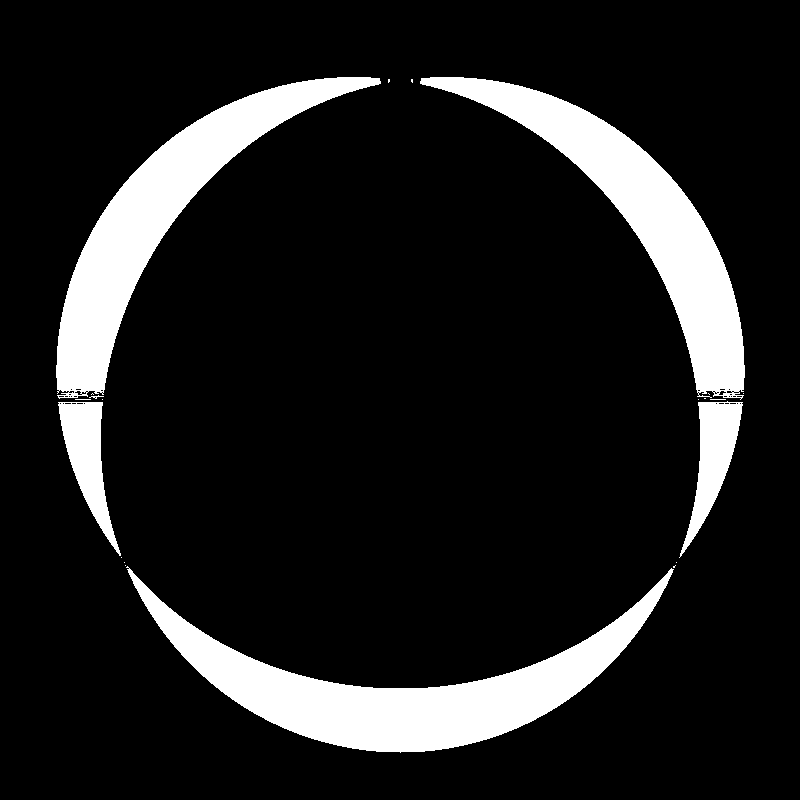

In [19]:
ia = main()
vf = Image.fromarray(ia)
display(vf)

In [ ]:
x = -7.0
y = 10.0
z = 4.0

dv = (0.0, 0.0, -1.0)
dr0 = (x,y,z)
hit = intersect(dr0,dv)
print(hit, x, y, z)

In [ ]:
w1(4, 0, *dr0, *dv)